In [9]:
#1. Dataset:
#o Use the Columbia University Object Image Library (COIL) dataset.
#o Split the dataset into training (80%) and testing (20%) sets.
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Download and load the dataset
import kagglehub

# Dataset details
dataset_handle = "codebreaker619/columbia-university-image-library"
path = kagglehub.dataset_download(dataset_handle)
print("Path to dataset files:", path)

# Function to load images and labels
def load_images_and_labels(dataset_dir):
    images = []
    labels = []
    for subdir, _, files in os.walk(dataset_dir):
        for file in files:
            if file.lower().endswith((".png", ".jpg")):
                file_path = os.path.join(subdir, file)
                image = Image.open(file_path).convert("RGB")
                images.append(np.array(image))
                label = os.path.basename(subdir)
                labels.append(label)
    return np.array(images), np.array(labels)

# Verify the dataset directory
dataset_dir = os.path.join(path, "coil-20/coil-20-proc")
if not os.path.exists(dataset_dir):
    raise FileNotFoundError(f"Dataset directory '{dataset_dir}' does not exist.")

# Load images and labels
images, labels = load_images_and_labels(dataset_dir)
if len(images) == 0:
    raise ValueError("No images found in the dataset directory.")

Path to dataset files: /root/.cache/kagglehub/datasets/codebreaker619/columbia-university-image-library/versions/1


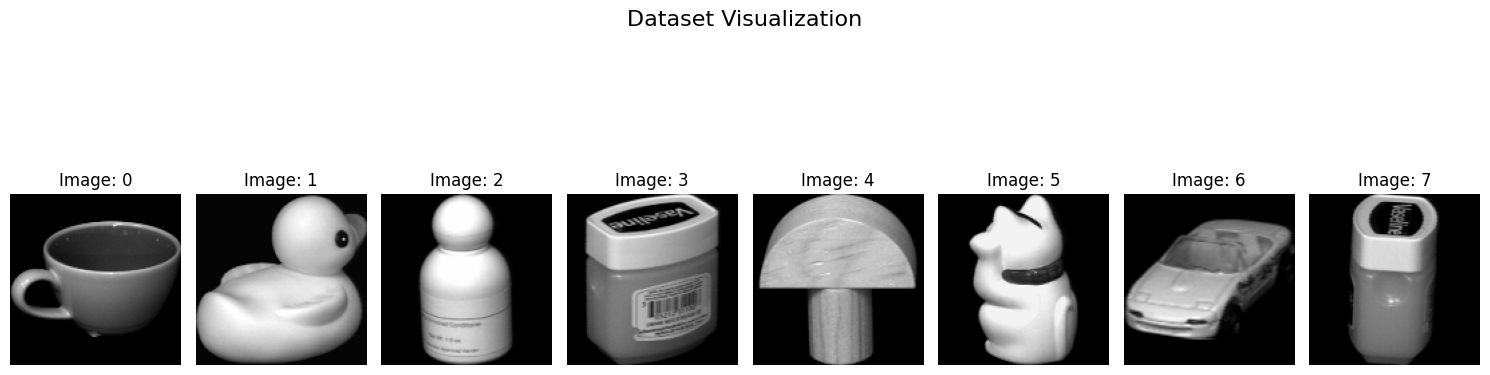

In [51]:
import matplotlib.pyplot as plt

# Visualize a few images from the dataset
def visualize_dataset(images, labels, num_images=8):
    plt.figure(figsize=(15, 5))
    plt.suptitle("Dataset Visualization", fontsize=16)
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(f"Image: {i}")
        plt.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Visualize a few images
if len(images) > 0:
    visualize_dataset(images, labels, num_images=8)
else:
    print("No images loaded for visualization.")


In [13]:
# Split dataset(80% and 20%)
images, labels = shuffle(images, labels, random_state=42)
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

# Normalize pixel values to [0,1]
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0


In [34]:
#2. Model Development:
#o Construct a CNN Autoencoder with:
#▪ Encoder: Use convolutional layers with ReLU activation to reduce the input image to a lower-dimensional latent representation.
#▪ Decoder: Use transpose convolutional layers to reconstruct the image from the latent space.

# Creating the encoder and decoder
def create_autoencoder(input_shape):
    # Encoder
    encoder_input = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    encoded = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)

    # Decoder
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(encoded)
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
    decoded = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

    return keras.Model(encoder_input, decoded)

# Input shape
input_shape = (128, 128, 3)
train_images_resized = tf.image.resize(train_images, input_shape[:2])
test_images_resized = tf.image.resize(test_images, input_shape[:2])

# Initialize and compile autoencoder
autoencoder = create_autoencoder(input_shape)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")
autoencoder.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_10                  │ (None, 64, 64, 64)          │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_11                  │ (None, 128, 128, 32)        │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 128, 128, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 186,371 (728.01 KB)

 Trainable params: 186,371 (728.01 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
#3. Training:
#o Use the Mean Squared Error (MSE) loss function.
#o Use Adam optimizer with a learning rate of 0.001.(Both of these step are in the above code block)
#o Train the model for 20 epochs with a suitable batch size.

# Train the autoencoder
history = autoencoder.fit(
    train_images_resized,
    train_images_resized,
    epochs=20,
    batch_size=32,
    shuffle=True,
    validation_data=(test_images_resized, test_images_resized)
)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.1624e-04
Test Loss (MSE): 0.0009803117718547583
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


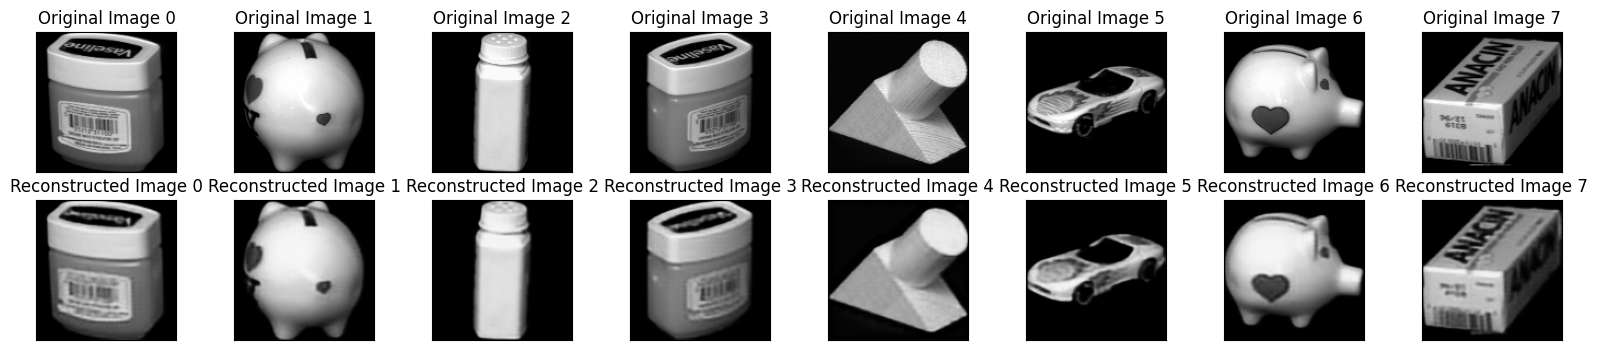

MSE for image 0: 0.001975047867745161
MSE for image 1: 0.0004660921113099903
MSE for image 2: 0.00038425158709287643
MSE for image 3: 0.0013964892132207751
MSE for image 4: 0.0006045367917977273
MSE for image 5: 0.0008409796864725649
MSE for image 6: 0.0005974052473902702
MSE for image 7: 0.0014414209872484207
Average MSE on the test set: 0.0009803116554394364


In [41]:
#4. Evaluation:
#o Evaluate the model's performance using the testing set.
#o Visualize the reconstructed images and compare them to the original images.
#o Calculate and report the MSE on the test set.


# Evaluate the model
loss = autoencoder.evaluate(test_images_resized, test_images_resized)
print(f"Test Loss (MSE): {loss}")

# Predict on the test set
reconstructed_images = autoencoder.predict(test_images_resized)

# Visualize reconstructed images and compare them to original images
n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"Original Image {i}")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i])
    plt.title(f"Reconstructed Image {i}")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Calculate MSE per image
mse_per_image = np.mean(np.square(test_images_resized - reconstructed_images), axis=(1, 2, 3))

# Print MSE for each image
for i in range(n):
    print(f"MSE for image {i}: {mse_per_image[i]}")

# Report the average MSE over all test images
average_mse = np.mean(mse_per_image)
print(f"Average MSE on the test set: {average_mse}")

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_10                  │ (None, 64, 64, 64)          │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_11                  │ (None, 128, 128, 32)        │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 128, 128, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 559,115 (2.13 MB)

 Trainable params: 186,371 (728.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 372,744 (1.42 MB)

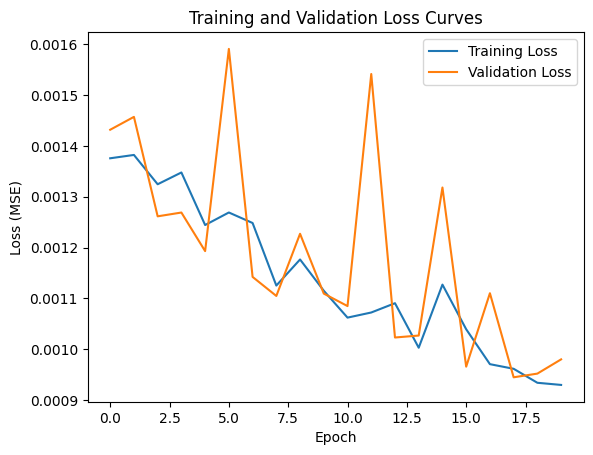

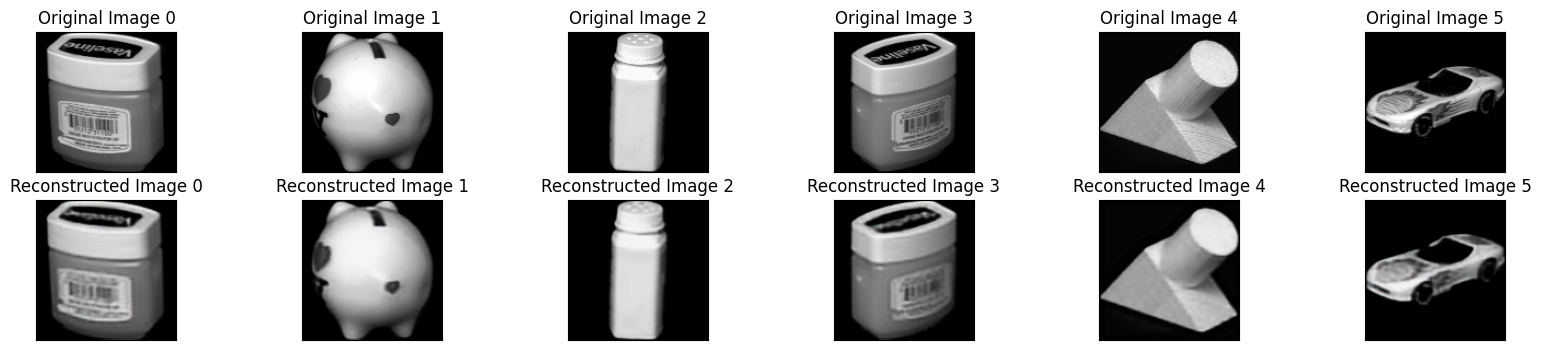

Final Test MSE: 0.0009803117718547583


In [52]:
# Deliverables:

# 1. Architecture of the CNN Autoencoder.
autoencoder.summary()


# 2. Loss curve during training.

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()


# 3. Original vs. reconstructed images (at least 5 examples).

# Visualize reconstructed images and compare them to original images
n = 6
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"Original Image {i}")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i])
    plt.title(f"Reconstructed Image {i}")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


# 4. Final test MSE value.

# Print the final test MSE value
print(f"Final Test MSE: {loss}")



**Insights:**


The final value of **mse** is **0.0010096165351569653.** Which means that the original image and reconstructed image are kind of simmilar ie the reconstcuted image does not have that much diffrence when compaired to the original image.

The **loss curve** plotted with the training and validation loss ,only have small varaition from the each other.

The reconstructed images are a bit blured other thatn that these is not much diffrence between the original and the reconstructed image.

The encoder comparess the image smaller while the decoder uses the output of the encoder to recnostruct the image back.



